# CIS 9655 Final Project - Jersey City Citi Bike Data Visualization 
#### Name: Qinyuan Lu
#### Instructor:  Anna O'Connell

## Data Source

This Project combined 2 different datasets: 

Bike Trips:

The bike trips record dataset is from Citi Bike: Each row of record represents Daily Ridership and Membership Data, and Trip Histories.
https://www.citibikenyc.com/system-data

Weather:

Weather dataset included daily weather summaries for the first half year of 2020 in Jersey City and have multiple dimensions.
http://newa.cornell.edu/index.php?page=hourly-weather

## Big Idea

Citi Bike is the operator for Jersey City's bike sharing service. The following visuals show correlation between ridership and different factors, including weather, time, age and gender. Among the weather factors, air temperature has the highest corralation with the number of ridership.

### Import data:

In [215]:
import pandas as pd
import numpy as np
from pylab import rcParams
import matplotlib.pyplot as plt
import seaborn as sns 
import statsmodels.api as sm
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import *
from sklearn.kernel_ridge import *
from sklearn.svm import *
from sklearn.metrics import *
from sklearn.naive_bayes import GaussianNB
from dmba import regressionSummary, adjusted_r2_score

In [216]:
df1=pd.read_csv('JC-202001-citibike-tripdata.csv')
df2=pd.read_csv('JC-202002-citibike-tripdata.csv')
df3=pd.read_csv('JC-202003-citibike-tripdata.csv')
df4=pd.read_csv('JC-202004-citibike-tripdata.csv')
df5=pd.read_csv('JC-202005-citibike-tripdata.csv')
df6=pd.read_csv('JC-202006-citibike-tripdata.csv')

/Users/luqinyuan/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (16,19,20,21) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [217]:
frames = [df1, df2, df3, df4, df5, df6]
df = pd.concat(frames, sort=False)

In [218]:
df.head()

,tripduration,Date,Hour,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,...,usertype,birth year,gender,Air Temp (?H),Precip (inches),RH (%),Wind Spd (mph),Wind Dir (degrees),Solar Rad (watts/m2),Dewpoint (?H)
0,226,1/1/20,0,3186,Grove St PATH,40.719586,-74.043117,3211,Newark Ave,40.721525,...,Subscriber,1984,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,377,1/1/20,0,3186,Grove St PATH,40.719586,-74.043117,3269,Brunswick & 6th,40.726012,...,Subscriber,1989,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,288,1/1/20,0,3186,Grove St PATH,40.719586,-74.043117,3269,Brunswick & 6th,40.726012,...,Customer,1989,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,435,1/1/20,0,3195,Sip Ave,40.730897,-74.063913,3280,Astor Place,40.719282,...,Customer,1969,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,231,1/1/20,0,3186,Grove St PATH,40.719586,-74.043117,3276,Marin Light Rail,40.714584,...,Subscriber,1983,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 1. Data Cleaning

### 1.1 Missing Value

In [219]:
# count missing vaues in each column
df.isnull().sum()

tripduration                0
Date                        0
Hour                        0
start station id            0
start station name          0
start station latitude      0
start station longitude     0
end station id              0
end station name            0
end station latitude        0
end station longitude       0
bikeid                      0
usertype                    0
birth year                  0
gender                      0
Air Temp (?H)              10
Precip (inches)            10
RH (%)                     10
Wind Spd (mph)             10
Wind Dir (degrees)         10
Solar Rad (watts/m2)       10
Dewpoint (?H)              10
dtype: int64

In [220]:
#drop rows with missing value
df = df.dropna(how = 'any')
df.shape

(137957, 22)

### 1.2 Change Data type

In [221]:
#check data types
df.dtypes

tripduration                 int64
Date                        object
Hour                         int64
start station id             int64
start station name          object
start station latitude     float64
start station longitude    float64
end station id               int64
end station name            object
end station latitude       float64
end station longitude      float64
bikeid                       int64
usertype                    object
birth year                   int64
gender                       int64
Air Temp (?H)              float64
Precip (inches)             object
RH (%)                     float64
Wind Spd (mph)             float64
Wind Dir (degrees)          object
Solar Rad (watts/m2)        object
Dewpoint (?H)               object
dtype: object

In [222]:
# convert date into Datetime 
df['Date'] = pd.to_datetime(df['Date'])

In [223]:
# dropping records with gender code  = 0
df = df[df.gender != 0 ]

In [224]:
# function to categorize Gender
def gender_cat(gender):
    if gender == 1:
        return 'Male'
    elif gender == 2:
        return 'Female'
    else:
        return 'Unknown'

In [225]:
# get a new "Gender_Cat" Column
df['Gender_Cat'] =df['gender'].apply(gender_cat)

In [226]:
# mainly focus on 4 weather factors: Air Temp, Precip, RH, and Wind Spd 

# rename the column names 
df.rename({'Air Temp (?H)': 'air_temp', \
           'Precip (inches)': 'precip',
           'RH (%)': 'humidity',
           'Wind Spd (mph)': 'wind_spd'}, axis=1, inplace=True)

# drop unrelated columns
df.drop('Wind Dir (degrees)', axis= 1, inplace= True)
df.drop('Solar Rad (watts/m2)', axis= 1, inplace= True)
df.drop('Dewpoint (?H)', axis= 1, inplace= True)

In [227]:
# check unique values
df['precip'].unique()

array([0.0, 0.01, 0.02, 0.05, 0.03, 0.04, 0.06, 0.16, 0.47, 0.07, 0.19,
       0.18, 0.08, 0.14, 0.12, 0.27, 0.26, 0.09, 0.22, 0.23, 0.1, 0.11,
       0.21, 0.15, 0.17, '0', '0.04', '0.34', '0.22', '0.01', '0.09',
       '0.11', '0.15', '0.02', '-', '0.06', '0.03', '0.17', 0.13],
      dtype=object)

In [228]:
# drop records with "-" value in "precip"
df = df[df.precip != '-']
# change the "Precip" data type to float 
df['precip'] = df['precip'].astype(float)

In [229]:
#check data types
df.dtypes

tripduration                        int64
Date                       datetime64[ns]
Hour                                int64
start station id                    int64
start station name                 object
start station latitude            float64
start station longitude           float64
end station id                      int64
end station name                   object
end station latitude              float64
end station longitude             float64
bikeid                              int64
usertype                           object
birth year                          int64
gender                              int64
air_temp                          float64
precip                            float64
humidity                          float64
wind_spd                          float64
Gender_Cat                         object
dtype: object

In [230]:
df.head()

,tripduration,Date,Hour,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender,air_temp,precip,humidity,wind_spd,Gender_Cat
10,1227,2020-01-01,1,3186,Grove St PATH,40.719586,-74.043117,3280,Astor Place,40.719282,-74.071262,29467,Subscriber,1976,1,40.1,0.0,62.0,7.1,Male
11,360,2020-01-01,1,3185,City Hall,40.717733,-74.043845,3209,Brunswick St,40.724176,-74.050656,29290,Subscriber,1984,1,40.1,0.0,62.0,7.1,Male
12,478,2020-01-01,1,3792,Columbus Dr at Exchange Pl,40.716870,-74.032810,3276,Marin Light Rail,40.714584,-74.042817,26155,Subscriber,1963,1,40.1,0.0,62.0,7.1,Male
13,446,2020-01-01,1,3792,Columbus Dr at Exchange Pl,40.716870,-74.032810,3276,Marin Light Rail,40.714584,-74.042817,29673,Subscriber,1964,2,40.1,0.0,62.0,7.1,Female
14,583,2020-01-01,1,3275,Columbus Drive,40.718355,-74.038914,3199,Newport Pkwy,40.728745,-74.032108,26250,Customer,1990,2,40.1,0.0,62.0,7.1,Female


In [231]:
df.shape

(119473, 20)

### 1.3 group by hour in each day to get a new column "rented_bike_count"

In [232]:
# group by date and hour to get the target variable: "rented_bike_count"
df1 = df.groupby(["Date","Hour","air_temp","precip","humidity","wind_spd"])["Hour"].count().reset_index(name='rented_bike_count')
df1.head()

,Date,Hour,air_temp,precip,humidity,wind_spd,rented_bike_count
0,2020-01-01,1,40.1,0.0,62.0,7.1,13
1,2020-01-01,2,39.7,0.0,65.0,2.0,8
2,2020-01-01,3,39.4,0.0,63.0,0.1,6
3,2020-01-01,4,38.8,0.0,59.0,0.1,2
4,2020-01-01,5,38.3,0.0,56.0,5.8,2


## 2. Data Visualization

### 2.1 Number of Trips per day during Jan - June 2020

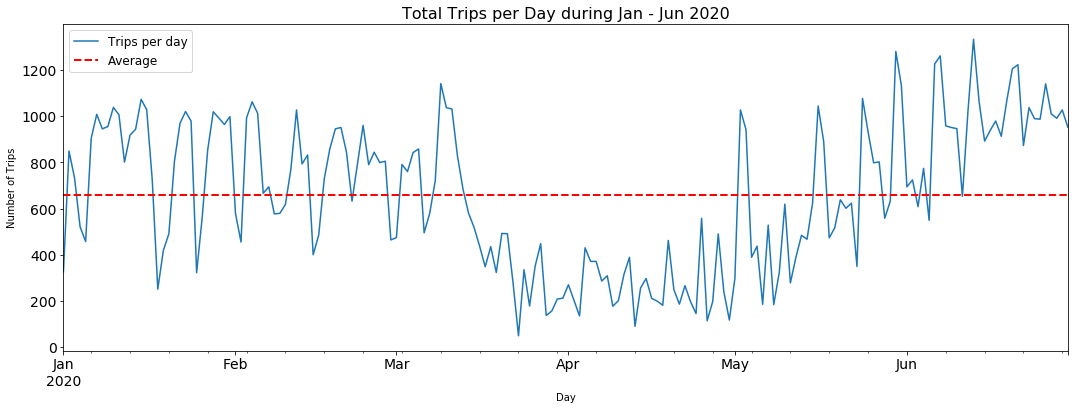

In [233]:
bike_daily = pd.DataFrame(df.groupby('Date').size())
bike_daily['MEAN'] = df.groupby('Date').size().mean()
bike_daily['STD'] = df.groupby('Date').size().std()

plt.figure(figsize=(18,6))
df.groupby('Date').size().plot(label='Trips per day')
bike_daily['MEAN'].plot(color='red', linewidth=2, label='Average', ls='--')
plt.title('Total Trips per Day during Jan - Jun 2020', fontsize=16)
plt.xlabel('Day')

plt.ylabel('Number of Trips')
plt.tick_params(labelsize=14)
plt.legend(prop={'size':12})

__Analysis:__

The 'number of trips' rises sharply from June (Summer Start)

The 'number of trips' during mid March to April is consistently below average

### 2.2 Number of Trips per Hour during a Day

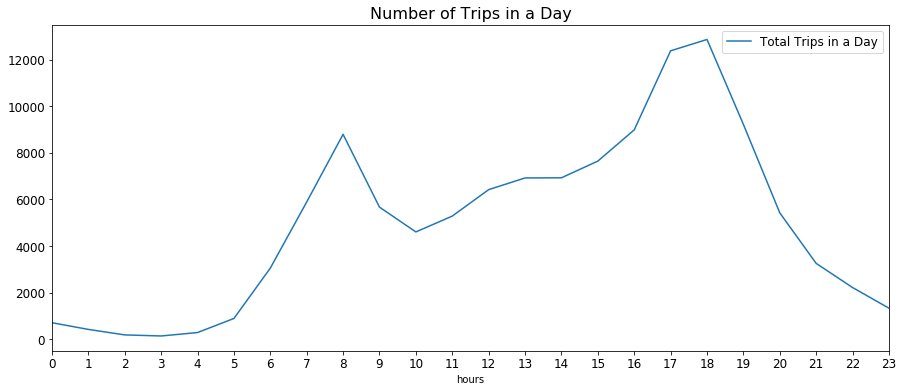

In [234]:
plt.figure(figsize=(15,6))

df.groupby('Hour').size().plot(label = 'Total Trips in a Day')
plt.title('Number of Trips in a Day', fontsize=16)
plt.xlabel('hours')
plt.xticks(np.arange(0,24))
plt.legend(prop={'size':12})
plt.tick_params(labelsize=12)

__Analysis:__

The number of trips on the road is highest at 8 AM & between 5 - 6 PM

The number of trips on the road is at its lowest around 3 -4 AM

### 2.3 Gender & Number of Trips

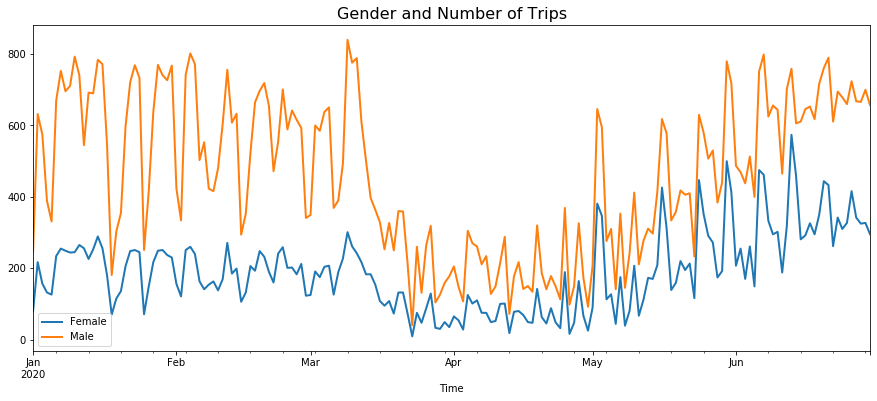

In [235]:
bikes_stat_gender = df.pivot_table(values='gender', index='Date', columns='Gender_Cat', aggfunc=len).plot(figsize=(15,6), linewidth=2)
plt.title('Gender and Number of Trips', fontsize=16)
plt.xlabel('Time')
plt.legend(prop={'size':10})
plt.tick_params(labelsize=10)

__Analysis:__

There are consistently fewer female bikers than male bikers

### 2.4 Age & Number of Trips

Text(0.5, 1.0, 'Age and Number of Trips')

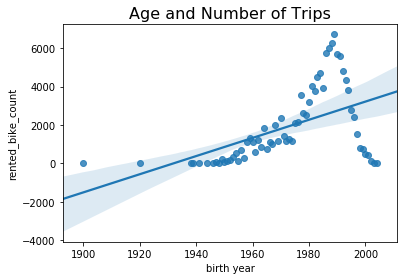

In [236]:
Age_graph = df.groupby(["birth year"])["bikeid"].count().reset_index(name='rented_bike_count')
sns.regplot(x="birth year",y="rented_bike_count",data=Age_graph)
plt.title('Age and Number of Trips', fontsize=16)

__Analysis__

This graph above shows how much bikes are rented by rider's birth year. 

- Middle age population (30-40), especially 90s are the biggest group of users of Citi Bike.
- Newer generation people (1990 onwards) become less interested in shared biking. 

### 2.5 Frequency of hourly rideship

Text(0.5, 1.0, 'Distribution of Bike Rental by Hour')

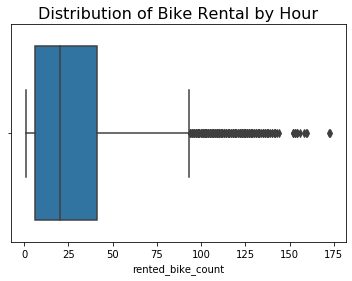

In [238]:
ax = sns.boxplot(x=df1["rented_bike_count"])
plt.title('Distribution of Bike Rental by Hour', fontsize=16)

Boxplot displays the position of the median value of rented bike count by hour, which is around 20.

There is a long tail in the data distribution.

### 2.6 Weather Factors

#### 2.6.1 Visualizing Distribution of Weather Data

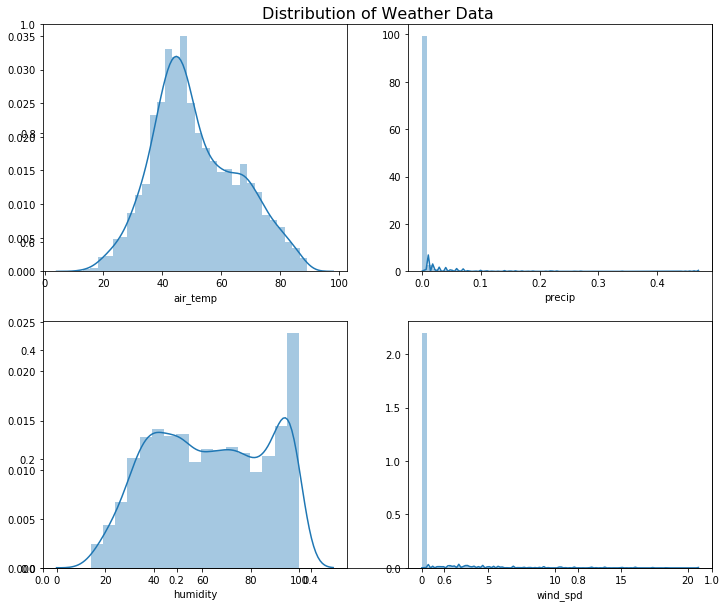

In [239]:
fig = plt.figure(figsize=[12,10])
plt.title('Distribution of Weather Data', fontsize=16)
ax1 = fig.add_subplot(2,2,1)
ax1 = sns.distplot(df1.air_temp)

ax2 = fig.add_subplot(2,2,2)
ax2 = sns.distplot(df1.precip)

ax3 = fig.add_subplot(2,2,3)
ax3 = sns.distplot(df1.humidity)

ax4 = fig.add_subplot(2,2,4)
ax4 = sns.distplot(df1.wind_spd)



These viauls simply shows the 4 weather factors' data distribution. 

#### 2.6.2 correlation matrix

In [242]:
corrMatrix = df1.corr()
print (corrMatrix)

                       Hour  air_temp    precip  humidity  wind_spd  \
Hour               1.000000  0.165672 -0.001089 -0.229503  0.026812   
air_temp           0.165672  1.000000 -0.012651 -0.054090  0.091526   
precip            -0.001089 -0.012651  1.000000  0.215607 -0.016948   
humidity          -0.229503 -0.054090  0.215607  1.000000 -0.120711   
wind_spd           0.026812  0.091526 -0.016948 -0.120711  1.000000   
rented_bike_count  0.269621  0.267874 -0.090525 -0.219699  0.062324   

                   rented_bike_count  
Hour                        0.269621  
air_temp                    0.267874  
precip                     -0.090525  
humidity                   -0.219699  
wind_spd                    0.062324  
rented_bike_count           1.000000  


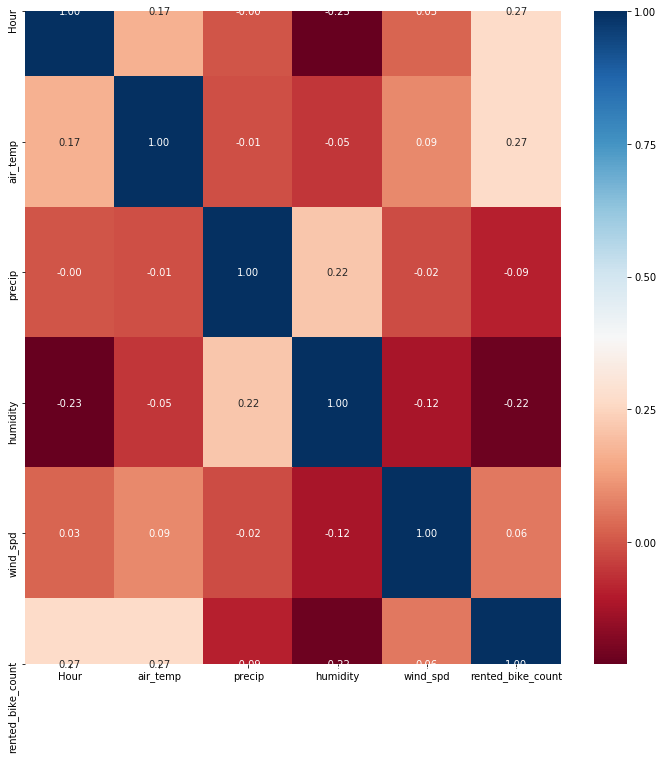

In [243]:
fig, ax = plt.subplots()
fig.set_size_inches(12, 12)
sns.heatmap(corrMatrix, annot=True, fmt=".2f", cmap="RdBu", ax=ax)
plt.show()

__Analysis:__

Among the weather variables, "air_temp" has the highest correlation value of 0.27.

#### 2.6.3 Scatter plot between air_temp and rented_bike_count

Text(0.5, 1.0, 'air_temp and Number of Trips')

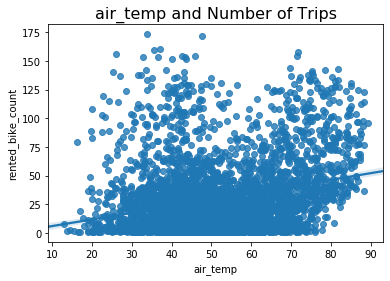

In [244]:
sns.regplot(x="air_temp",y="rented_bike_count",data=df1)
plt.title('air_temp and Number of Trips', fontsize=16)

__Analysis:__

We can see from the above graph, the ridership will increase when the air temperature goes higher. 